# Uso de redes já prontas com pesos vencedores da ImageNet

Uma das grandes vantagens que a competição ImageNet trouxe à comunidade é o uso tanto das arquiteturas como dos pesos utilizados pelos vencedores da ImageNet em cada ano.

Estas arquiteturas tem trazido melhorias nos desempenhos desde 2012.

As principais redes vencedoras estão disponíveis no `PyTorch` em  
- [Modelos de redes ImageNet no Pytorch](https://github.com/pytorch/vision/blob/master/torchvision/models)

<img src='../figures/networks_comparison.png', width=500></img>

<img src='../figures/AlexNet.png', width=500></img>

<img src="../figures/VGG19.png", width= 500pt></img>

<img src='../figures/GoogLenet.png', width=700></img>

<img src='../figures/Inception_module.png', width=500></img>

<img src='../figures/ResNet.png',width=700></img>

<img src='../figures/ResNet_module.png', width=500></img>

## Importação dos módulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms

import torchvision
from PIL import Image
import json

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Funções de preprocessamento da ImageNet

In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = '/data/datasets/imagenet_class_index.json'
def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        with open(CLASS_INDEX_PATH, 'r') as file:
            CLASS_INDEX = json.load(file)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


## Escolha da rede com pesos já pretreinados

In [17]:
MODEL = {
    'alexnet':     torchvision.models.alexnet,
    'vgg11':       torchvision.models.vgg11,
    'vgg19':       torchvision.models.vgg19,
    'vgg11bn':     torchvision.models.vgg11_bn,
    'vgg19bn':     torchvision.models.vgg19_bn,
    'resnet18':    torchvision.models.resnet18,
    'resnet152':   torchvision.models.resnet152,
    'squeezenet':  torchvision.models.squeezenet1_1,
    
}

#model = torchvision.models.vgg19(pretrained=True)
model = MODEL['resnet18'](pretrained=True)

print(model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

## Escolha da imagem de teste

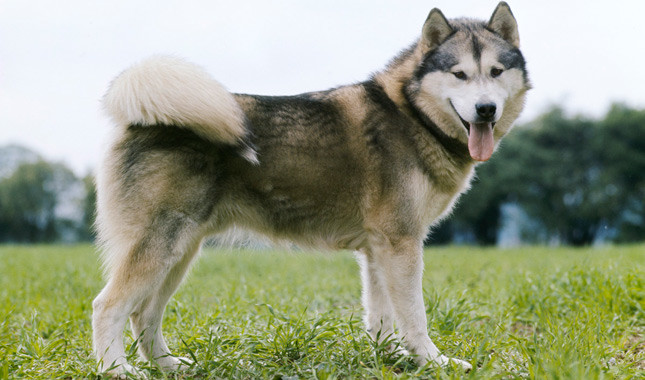

In [18]:
img_path = '/data/datasets/images/malamute.jpeg'
#img_path = '/data/datasets/images/egyptian cat.jpeg'
#img_path = '/data/datasets/images/hay.jpg'
#img_path = '/data/datasets/images/tank.jpg'

img = Image.open(img_path)
img

(380, 645, 3)

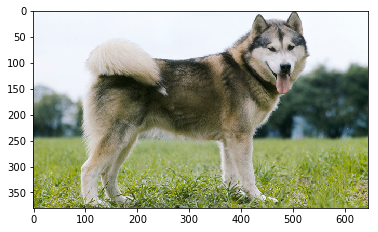

In [12]:
# Convertendo para NumPy Array e mostrando com matplotlib
x = np.array(img)
plt.imshow(x)
x.shape

In [13]:
format_image = transforms.Compose([
    transforms.Scale((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inputs = format_image(img)

inputs = Variable(inputs.unsqueeze(0))
print(inputs.size())

torch.Size([1, 3, 300, 300])


## Predict da rede

In [14]:
output = torch.nn.functional.softmax(model(inputs))

1 loop, best of 3: 174 ms per loop


## Resultado, já com a classe da ImageNet

In [15]:
print('Predicted:')
for i, sample in enumerate(decode_predictions(output.data.numpy())):
    print('\nImagem ', i)
    for rank, prediction in enumerate(sample):
        print('{}: {:20} - score: {:2.3f}'.format(rank+1, prediction[1], prediction[2]))

Predicted:

Imagem  0
1: Norwegian_elkhound   - score: 0.562
2: malamute             - score: 0.230
3: Eskimo_dog           - score: 0.108
4: Siberian_husky       - score: 0.070
5: German_shepherd      - score: 0.020


## Atividade

1. Meça o tempo de predição de cada rede e complete a tabela abaixo

| Rede     | Tempo |
|----------|-------|
|AlexNet   |       |
|VGG11     |       |
|VGG19     |       |
|ResNet18  |       |
|ResNet152 |       |
|SqueezeNet|       |
